# Modelo Naive Bayes (MultinomialNB) para detección de mensajes tóxicos

En este notebook entrenamos un modelo clásico de **Naive Bayes (MultinomialNB)** para detectar
comentarios tóxicos (`IsToxic`) en el dataset preprocesado:

- Cargamos el dataset ya **preprocesado** (`data/preprocessing_data/youtoxic_english_1000_clean.csv`).
- Usamos como texto base la columna `text_classic`.
- Incorporamos **5 features numéricas** ya generadas en el preprocesado::
  - `text_len_classic`
  - `word_count_classic`
  - `uppercase_ratio`
  - `exclamation_count`
  - `hate_words_count`
- Construimos un **pipeline de scikit-learn** con:
  1. `TfidfVectorizer` (``TF-IDF`) sobre el texto.
  2. Concatenación (o paso directo `passthrough`) con las features numéricas.
  3. Clasificador `MultinomialNB`.

Al final del notebook:

- Entrenaremos el modelo con un **train/test split (80/20)**.
- Evaluamos métricas estándar: accuracy, precision, recall, F1, ROC-AUC y matriz de confusión.
- Mostramos gráficos:
  - Matriz de confusión
  - Curva ROC
- Guardaremos:
  - El modelo entrenado (`backend/models/<nombre_modelo>.pkl`)
  - Los resultados de las métricas en JSON (`.json`) en `data/results/` (`data/results/<nombre_modelo>.json`) siguiendo el formato acordado para el resto de notebooks de modelos y facilitar la comparación.


### 1. Importación de librerías y configuración

En esta celda:

- Importamos librerías para:
  - Manejo de rutas y fechas (`pathlib`, `datetime`)
  - Manejo de datos (`pandas`, `numpy`)
  - Machine Learning clásico con scikit-learn:
    - División en train/test
    - Vectorización de texto (`TfidfVectorizer`)
    - Combinación de columnas (`ColumnTransformer`, `Pipeline`)
    - Clasificador Naive Bayes (`MultinomialNB`)
    - Cálculo de métricas
  - Visualización (`matplotlib`)
  - Persistencia de modelos (`joblib`)
  - Guardado de resultados en JSON (`json`)
- Definimos variables de configuración:
  - Columna objetivo (`TARGET_COL`)
  - Columna de texto (`TEXT_COL`)
  - Lista de features numéricas
  - Nombre del modelo
  - Semilla (`RANDOM_STATE`) para reproducibilidad.


In [2]:
# === 1. Import libraries and global configuration ============================

import json  # To save metrics in JSON format
from datetime import datetime  # To generate ISO timestamp
from pathlib import Path  # To handle file system paths

import numpy as np  # Numerical operations
import pandas as pd  # DataFrame handling

# Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split  # Train/test split
from sklearn.feature_extraction.text import TfidfVectorizer  # Text vectorization
from sklearn.compose import ColumnTransformer  # Combine text + numeric features
from sklearn.pipeline import Pipeline  # Build end-to-end ML pipeline
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier for text

# Metrics
from sklearn.metrics import (
    accuracy_score,                       # Accuracy
    precision_recall_fscore_support,      # Precision, recall, F1 in one call
    roc_auc_score,                        # ROC-AUC
    confusion_matrix,                     # Confusion matrix
    classification_report,                # Detailed metrics per class
    roc_curve                             # ROC curve points
)

# Model persistence
import joblib  # To save/load trained models

# Visualization
import matplotlib.pyplot as plt  # For plots (confusion matrix, ROC curve)
from IPython.display import display, Markdown  # Pretty printing in notebooks

import warnings  # To ignore some sklearn warnings
warnings.filterwarnings("ignore")

# --- Global configuration ----------------------------------------------------

RANDOM_STATE = 42  # Fixed seed for reproducibility

# Target and feature columns
TARGET_COL = "IsToxic"          # Binary target
TEXT_COL = "text_classic"       # Main text column after preprocessing

numeric_features = [            # Numerical features extracted in preprocessing
    "text_len_classic",
    "word_count_classic",
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count"
]

# Model name (used for saving .pkl and .json)
model_name = "naive_bayes_multinomial_IsToxic"

print("✅ Librerías importadas y configuración global definida correctamente")
print(f"🎯 Columna objetivo: {TARGET_COL}")
print(f"📝 Columna de texto: {TEXT_COL}")
print(f"🔢 Features numéricas: {numeric_features}")
print(f"🧠 Nombre del modelo: {model_name}")
print(f"🎲 RANDOM_STATE: {RANDOM_STATE}")


✅ Librerías importadas y configuración global definida correctamente
🎯 Columna objetivo: IsToxic
📝 Columna de texto: text_classic
🔢 Features numéricas: ['text_len_classic', 'word_count_classic', 'uppercase_ratio', 'exclamation_count', 'hate_words_count']
🧠 Nombre del modelo: naive_bayes_multinomial_IsToxic
🎲 RANDOM_STATE: 42


### 2. Carga del dataset limpio

En esta celda:

- Localizamos la **raíz del proyecto**:
  - Si estamos en `backend/notebooks`, subimos un nivel.
  - Si estamos en la raíz, usamos el directorio actual.
- Construimos la ruta a:
  - `data/preprocessing_data/youtoxic_english_1000_clean.csv`
- Cargamos el CSV preprocesado con `pandas`.
- Mostramos:
  - Dimensiones del dataset
  - Primeras filas
  - Tipos de datos
  - Distribución básica de la etiqueta `IsToxic`.

Esto nos sirve para verificar que:
- Estamos usando el **dataset correcto**.
- La columna objetivo existe y es binaria.
- Las features numéricas están presentes en el DataFrame.


In [14]:
# === 2. Load preprocessed dataset ===========================================

# Detect project root (one level above "backend" if we are inside notebooks)
current_dir = Path.cwd()
if "notebooks" in str(current_dir):
    project_root = current_dir.parent.parent  # .../PX_NLP_G4
else:
    project_root = current_dir

print("📂 Directorio actual:", current_dir)
print("📁 Raíz del proyecto detectada:", project_root)

# Path to the clean preprocessed dataset
data_clean_path = project_root / "data" / "preprocessing_data" / "youtoxic_english_1000_clean.csv"
print("\n📄 Cargando dataset limpio desde:")
print(f"   {data_clean_path}")


def get_project_root() -> Path:
    """Return PX_NLP_G4 project root folder."""
    cwd = Path.cwd()
    parts = cwd.parts

    if "notebooks" in parts:
        return cwd.parents[1]
    if cwd.name == "backend":
        return cwd.parent
    return cwd

project_root = get_project_root()

data_dir = project_root / "data"
preproc_dir = data_dir / "preprocessing_data"
results_dir = data_dir / "results"
models_dir = project_root / "backend" / "models"

print("📂 project_root:", project_root)
print("📂 data_dir:", data_dir)
print("📂 preprocessing_data:", preproc_dir)
print("📂 results_dir:", results_dir)
print("📂 models_dir:", models_dir)

csv_path = preproc_dir / "youtoxic_english_1000_clean.csv"

df = pd.read_csv(csv_path)
print(f"\n✅ Dataset cargado: {csv_path}")
print(f"   Forma: {df.shape[0]} filas x {df.shape[1]} columnas")

# Load CSV
df = pd.read_csv(data_clean_path)

# Basic info
n_rows, n_cols = df.shape
print("\n📊 Dimensiones del dataset limpio:")
print(f"   Filas: {n_rows:,}")
print(f"   Columnas: {n_cols:,}")

print("\n🔍 Primeras filas del dataset:")
display(df.head(5))

print("\nℹ️ Tipos de datos por columna:")
print(df.dtypes)

# Check target distribution
if TARGET_COL in df.columns:
    print(f"\n📊 Distribución de la etiqueta '{TARGET_COL}':")
    print(df[TARGET_COL].value_counts(dropna=False))
    print("\n📊 Proporciones:")
    print(df[TARGET_COL].value_counts(normalize=True).round(3))
else:
    print(f"\n⚠️ La columna objetivo '{TARGET_COL}' no existe en el dataset. Revisa el nombre.")


📂 Directorio actual: c:\dev\proyectos\PX_NLP_G4\backend\notebooks
📁 Raíz del proyecto detectada: c:\dev\proyectos\PX_NLP_G4

📄 Cargando dataset limpio desde:
   c:\dev\proyectos\PX_NLP_G4\data\preprocessing_data\youtoxic_english_1000_clean.csv
📂 project_root: c:\dev\proyectos\PX_NLP_G4
📂 data_dir: c:\dev\proyectos\PX_NLP_G4\data
📂 preprocessing_data: c:\dev\proyectos\PX_NLP_G4\data\preprocessing_data
📂 results_dir: c:\dev\proyectos\PX_NLP_G4\data\results
📂 models_dir: c:\dev\proyectos\PX_NLP_G4\backend\models

✅ Dataset cargado: c:\dev\proyectos\PX_NLP_G4\data\preprocessing_data\youtoxic_english_1000_clean.csv
   Forma: 997 filas x 18 columnas

📊 Dimensiones del dataset limpio:
   Filas: 997
   Columnas: 18

🔍 Primeras filas del dataset:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate,text_basic,text_classic,text_len_classic,word_count_classic,uppercase_ratio,exclamation_count,hate_words_count
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,If only people would just take a step back and...,people would take step back make case wasnt an...,850,129,0.014121,0,2
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,Law enforcement is not trained to shoot to app...,law enforcement trained shoot apprehend traine...,90,13,0.036232,0,3
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,Dont you reckon them 'black lives matter' bann...,dont reckon black life matter banner held whit...,252,40,0.002375,0,1
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,There are a very large number of people who do...,large number people like police officer called...,339,49,0.015464,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,"The Arab dude is absolutely right, he should h...",arab dude absolutely right shot extra time sho...,138,23,0.020576,0,1



ℹ️ Tipos de datos por columna:
CommentId              object
VideoId                object
Text                   object
IsToxic                  bool
IsAbusive                bool
IsThreat                 bool
IsProvocative            bool
IsObscene                bool
IsHatespeech             bool
IsRacist                 bool
IsReligiousHate          bool
text_basic             object
text_classic           object
text_len_classic        int64
word_count_classic      int64
uppercase_ratio       float64
exclamation_count       int64
hate_words_count        int64
dtype: object

📊 Distribución de la etiqueta 'IsToxic':
IsToxic
False    538
True     459
Name: count, dtype: int64

📊 Proporciones:
IsToxic
False    0.54
True     0.46
Name: proportion, dtype: float64


### 3. División en entrenamiento y test

En esta celda:

- Definimos `X` (features) y `y` (target):
  - `X` incluye:
    - La columna de texto principal `text_classic`
    - Las 5 features numéricas creadas en el preprocesado.
  - `y` es la columna binaria `IsToxic`.
- Hacemos un `train_test_split` con:
  - `test_size = 0.2` → 80% train, 20% test
  - `random_state = RANDOM_STATE` → reproducible
  - `stratify = y` → mantiene la proporción de clases en train y test.

El objetivo es que **todos los modelos del proyecto** (LogReg, SVM, Naive Bayes, etc.) puedan usar la **misma partición** para que las métricas sean comparables.


In [4]:
# === 3. Train/test split =====================================================

# Define feature matrix X and target vector y
feature_cols = [TEXT_COL] + numeric_features  # Text + numeric features

# Safety check: ensure all feature columns exist
missing_cols = [col for col in feature_cols + [TARGET_COL] if col not in df.columns]
if missing_cols:
    raise ValueError(f"❌ Faltan columnas en el dataset: {missing_cols}")

X = df[feature_cols].copy()
y = df[TARGET_COL].astype(int).copy()

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("✅ División en entrenamiento y test completada\n")
print("📊 Tamaños de los conjuntos:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test:  {y_test.shape}")

print("\n📊 Distribución de la etiqueta en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True).round(3))

print("\n📊 Distribución de la etiqueta en el conjunto de test:")
print(y_test.value_counts(normalize=True).round(3))


✅ División en entrenamiento y test completada

📊 Tamaños de los conjuntos:
   X_train: (797, 6)
   X_test:  (200, 6)
   y_train: (797,)
   y_test:  (200,)

📊 Distribución de la etiqueta en el conjunto de entrenamiento:
IsToxic
0    0.54
1    0.46
Name: proportion, dtype: float64

📊 Distribución de la etiqueta en el conjunto de test:
IsToxic
0    0.54
1    0.46
Name: proportion, dtype: float64


### 4. Definición del pipeline de Naive Bayes

En esta celda definimos el **pipeline completo**:

1. **Transformador de texto**:
   - `TfidfVectorizer` aplicado sobre `text_classic`
   - `ngram_range=(1, 2)` → unigrams y bigrams
   - `max_features=10000` → limitar el vocabulario
2. **Transformador numérico**:
   - Paso directo (`passthrough`) para:
     - `text_len_classic`
     - `word_count_classic`
     - `uppercase_ratio`
     - `exclamation_count`
     - `hate_words_count`
3. **ColumnTransformer** para combinar:
   - Texto vectorizado (TF-IDF)
   - Features numéricas
4. **Clasificador**:
   - `MultinomialNB` (Naive Bayes Multinomial)

> 🔍 **Escalado**  
> No aplicamos `StandardScaler` ni normalización adicional porque:
> - `MultinomialNB` está pensado para **conteos / frecuencias no negativas**.
> - Nuestras features numéricas son conteos o ratios ≥ 0.
> - Un escalado tipo z-score generaría valores negativos y rompería el supuesto del modelo.


5. **Visualización esquemática del pipeline**

En esta celda mostramos un esquema visual simplificado del **pipeline de Naive Bayes**:

1. Entrada con:
   - `text_classic` (comentario en texto)
   - Features numéricas (`text_len_classic`, `word_count_classic`, etc.)
2. Bloque de **preprocesamiento**:
   - Texto → `TfidfVectorizer` (unigrams + bigrams)
   - Variables numéricas → se pasan tal cual
3. Bloque de **modelo**:
   - Clasificador `MultinomialNB` (Naive Bayes Multinomial)

El objetivo es tener una visión rápida y visual del flujo completo:  
**datos → features → modelo → predicción**.



✅ Pipeline Naive Bayes definido correctamente

🧱 Estructura del pipeline:
Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=10000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text_classic'),
                                                 ('numeric', 'passthrough',
                                                  ['text_len_classic',
                                                   'word_count_classic',
                                                   'uppercase_ratio',
                                                   'exclamation_count',
                                                   'hate_words_count'])])),
      

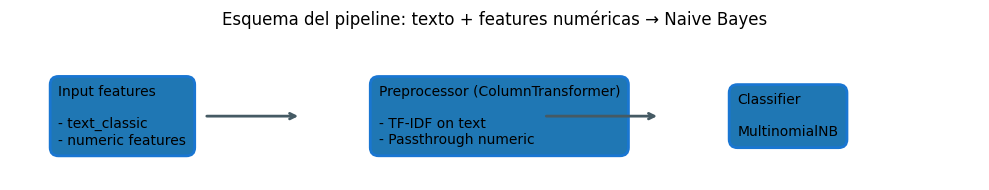


**🔍 Resumen visual del pipeline:**

1. Partimos de:
   - El texto original ya preprocesado (`text_classic`)
   - 5 variables numéricas derivadas (longitud, nº palabras, mayúsculas, exclamaciones, palabras de odio).
2. El bloque de *preprocesamiento*:
   - Convierte el texto en un vector TF-IDF (unigrams + bigrams).
   - Añade las variables numéricas sin escalado adicional.
3. El clasificador Naive Bayes (`MultinomialNB`) aprende a distinguir entre comentarios tóxicos y no tóxicos.


In [8]:
# === 4. Define Naive Bayes pipeline =========================================

from sklearn.preprocessing import FunctionTransformer  # Needed only if we wanted custom numeric transforms

# Text transformer: TF-IDF on the TEXT_COL
text_transformer = TfidfVectorizer(
    ngram_range=(1, 2),   # Use unigrams and bigrams
    max_features=10000,   # Limit vocabulary size
    min_df=2              # Ignore very rare terms
)

# ColumnTransformer to combine text + numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),          # Apply TF-IDF on text column
        ("numeric", "passthrough", numeric_features),  # Pass numeric features as-is
    ]
)

# Full pipeline: preprocessing + classifier
nb_clf = MultinomialNB()  # Naive Bayes classifier

pipeline = Pipeline(
    steps=[
        ("features", preprocessor),  # Feature engineering (text + numeric)
        ("classifier", nb_clf),      # Naive Bayes classifier
    ]
)

print("✅ Pipeline Naive Bayes definido correctamente")
print("\n🧱 Estructura del pipeline:")
print(pipeline)

# === 4.b Visual pipeline diagram ============================================

# Simple visual diagram of the pipeline using matplotlib

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("off")  # Hide axes

# Box style
box_style = dict(boxstyle="round,pad=0.6", edgecolor="#1976D2", linewidth=2)

# 1) Input box
ax.text(
    0.05,
    0.5,
    "Input features\n\n- text_classic\n- numeric features",
    fontsize=10,
    va="center",
    bbox=box_style,
)

# 2) Preprocessing box
ax.text(
    0.38,
    0.5,
    "Preprocessor (ColumnTransformer)\n\n- TF-IDF on text\n- Passthrough numeric",
    fontsize=10,
    va="center",
    bbox=box_style,
)

# 3) Model box
ax.text(
    0.75,
    0.5,
    "Classifier\n\nMultinomialNB",
    fontsize=10,
    va="center",
    bbox=box_style,
)

# Arrows between boxes
arrow_style = dict(arrowstyle="->", linewidth=2, color="#455A64")

ax.annotate("", xy=(0.30, 0.5), xytext=(0.20, 0.5), arrowprops=arrow_style)
ax.annotate("", xy=(0.67, 0.5), xytext=(0.55, 0.5), arrowprops=arrow_style)

ax.set_title("Esquema del pipeline: texto + features numéricas → Naive Bayes", fontsize=12, pad=20)

plt.tight_layout()
plt.show()

display(Markdown("""
**🔍 Resumen visual del pipeline:**

1. Partimos de:
   - El texto original ya preprocesado (`text_classic`)
   - 5 variables numéricas derivadas (longitud, nº palabras, mayúsculas, exclamaciones, palabras de odio).
2. El bloque de *preprocesamiento*:
   - Convierte el texto en un vector TF-IDF (unigrams + bigrams).
   - Añade las variables numéricas sin escalado adicional.
3. El clasificador Naive Bayes (`MultinomialNB`) aprende a distinguir entre comentarios tóxicos y no tóxicos.
"""))




### 5. Entrenamiento del modelo

En esta celda ajustamos el pipeline:

- `pipeline.fit(X_train, y_train)`:
  - Ajusta el `TfidfVectorizer` (aprende el vocabulario y los pesos IDF).
  - Combina texto + features numéricas.
  - Ajusta el clasificador `MultinomialNB`.

Guardamos el pipeline entrenado en una variable que luego utilizaremos para:

- Evaluar en el conjunto de test.
- Generar métricas y gráficos.
- Guardar el modelo en disco (`.pkl`).


In [9]:
# === 5. Train Naive Bayes model ============================================

print("⏳ Entrenando modelo Naive Bayes Multinomial...")
pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado")

# Quick info about learned vocabulary size
text_vectorizer = pipeline.named_steps["features"].named_transformers_["text"]
n_features_text = len(text_vectorizer.get_feature_names_out())
print(f"\n🔤 Número de features de texto (TF-IDF): {n_features_text}")
print(f"🔢 Número de features numéricas: {len(numeric_features)}")


⏳ Entrenando modelo Naive Bayes Multinomial...
✅ Entrenamiento completado

🔤 Número de features de texto (TF-IDF): 2065
🔢 Número de features numéricas: 5


### 6. Evaluación del modelo: métricas principales

En esta celda:

1. Obtenemos las predicciones en el conjunto de test:
   - `y_pred` → predicción binaria (0/1)
   - `y_proba` → probabilidad estimada de ser tóxico (`P(IsToxic=1)`)
2. Calculamos métricas:
   - `accuracy`
   - `precision`
   - `recall`
   - `f1`
   - `roc_auc` (usando probabilidades)
3. Calculamos la **matriz de confusión**:
   - `tn`, `fp`, `fn`, `tp`
4. Mostramos un **classification_report** para ver precisión/recall por clase.

Estas métricas son las que usaremos también para el **JSON de resultados** y la **comparación entre modelos**.


In [10]:
# === 6. Evaluate model on test set ==========================================

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
# For ROC-AUC, we need the probability for the positive class
if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
else:
    # Fallback: use decision function if available
    from sklearn.metrics import roc_auc_score
    y_scores = pipeline.decision_function(X_test)
    # We'll approximate probabilities via min-max scaling (not ideal, but fallback)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)
roc_auc = roc_auc_score(y_test, y_proba)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=" * 80)
print("📊 MÉTRICAS EN CONJUNTO DE TEST (Naive Bayes - IsToxic)")
print("=" * 80)
print(f"   Accuracy : {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall   : {recall:.4f}")
print(f"   F1-score : {f1:.4f}")
print(f"   ROC-AUC  : {roc_auc:.4f}")

print("\n🔢 Matriz de confusión (tn, fp, fn, tp):")
print(f"   TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")

print("\n📄 Classification report completo:")
print(classification_report(y_test, y_pred, digits=4))

print("\n💡 Interpretación rápida:")
print("   - Precision: de los comentarios que marcamos como tóxicos, cuántos lo son realmente.")
print("   - Recall: de todos los tóxicos reales, cuántos detecta el modelo.")
print("   - F1: equilibrio entre precision y recall.")
print("   - ROC-AUC: capacidad global de separar clases (0.5 = azar, 1.0 = perfecto).")


📊 MÉTRICAS EN CONJUNTO DE TEST (Naive Bayes - IsToxic)
   Accuracy : 0.7600
   Precision: 0.8333
   Recall   : 0.5978
   F1-score : 0.6962
   ROC-AUC  : 0.8014

🔢 Matriz de confusión (tn, fp, fn, tp):
   TN = 97, FP = 11, FN = 37, TP = 55

📄 Classification report completo:
              precision    recall  f1-score   support

           0     0.7239    0.8981    0.8017       108
           1     0.8333    0.5978    0.6962        92

    accuracy                         0.7600       200
   macro avg     0.7786    0.7480    0.7489       200
weighted avg     0.7742    0.7600    0.7531       200


💡 Interpretación rápida:
   - Precision: de los comentarios que marcamos como tóxicos, cuántos lo son realmente.
   - Recall: de todos los tóxicos reales, cuántos detecta el modelo.
   - F1: equilibrio entre precision y recall.
   - ROC-AUC: capacidad global de separar clases (0.5 = azar, 1.0 = perfecto).


### 7. Visualización: matriz de confusión y curva ROC

En esta celda generamos dos gráficos:

1. **Matriz de confusión**
   - Eje X: predicciones del modelo.
   - Eje Y: valores reales.
   - Nos ayuda a ver:
     - Cuántos verdaderos negativos (TN)
     - Cuántos falsos positivos (FP)
     - Cuántos falsos negativos (FN)
     - Cuántos verdaderos positivos (TP)

2. **Curva ROC**
   - Eje X: tasa de falsos positivos (FPR).
   - Eje Y: tasa de verdaderos positivos (TPR).
   - Cuanto más se acerque la curva a la esquina superior izquierda, mejor.
   - El área bajo la curva (AUC) resume la calidad del modelo en una sola cifra.

Esto complementa las métricas numéricas y hace más fácil **interpretar el comportamiento** del modelo.


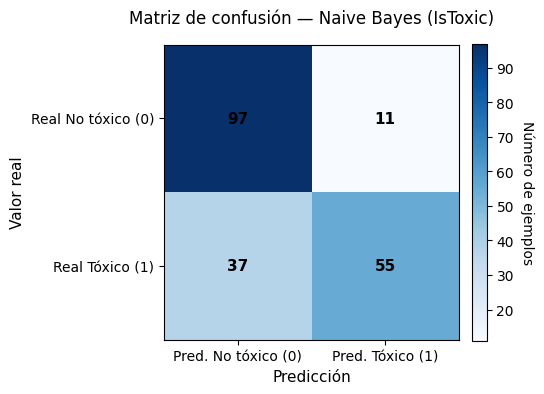


**📌 Interpretación de la matriz de confusión**

- **TN (verdaderos negativos)**: `97` → comentarios realmente *no tóxicos* que el modelo clasifica como *no tóxicos*.
- **FP (falsos positivos)**: `11` → comentarios *no tóxicos* que el modelo marca como *tóxicos*.
- **FN (falsos negativos)**: `37` → comentarios *tóxicos* que el modelo **no** detecta.
- **TP (verdaderos positivos)**: `55` → comentarios *tóxicos* correctamente detectados.

En este problema, los **FN** son especialmente importantes, porque representan mensajes de odio que se nos escaparían.


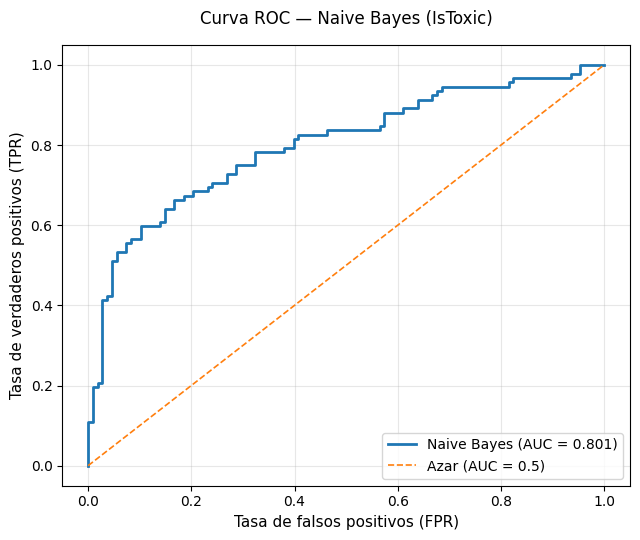


**📈 Curva ROC**

La curva ROC muestra el compromiso entre **TPR (sensibilidad)** y **FPR (falsos positivos)**.

- Un modelo aleatorio tendría una curva diagonal con AUC ≈ 0.5.
- Nuestro modelo Naive Bayes obtiene un **AUC = 0.801**, lo que indica
  una capacidad razonable para separar comentarios tóxicos de no tóxicos.


📈 Gráficos generados:
   - Matriz de confusión (estilo mejorado)
   - Curva ROC con AUC y línea de azar


In [11]:
# === 7. Plots: Confusion Matrix and ROC curve (styled) =======================

# 1) Confusion matrix heatmap (styled)
fig, ax = plt.subplots(figsize=(5.5, 5.0))

im = ax.imshow(cm, cmap="Blues")

# Tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred. No tóxico (0)", "Pred. Tóxico (1)"])
ax.set_yticklabels(["Real No tóxico (0)", "Real Tóxico (1)"])

# Labels and title
ax.set_xlabel("Predicción", fontsize=11)
ax.set_ylabel("Valor real", fontsize=11)
ax.set_title("Matriz de confusión — Naive Bayes (IsToxic)", fontsize=12, pad=15)

# Annotate each cell with counts
for i in range(2):
    for j in range(2):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="black",
            fontsize=11,
            fontweight="bold",
        )

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Número de ejemplos", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

display(Markdown(f"""
**📌 Interpretación de la matriz de confusión**

- **TN (verdaderos negativos)**: `{tn}` → comentarios realmente *no tóxicos* que el modelo clasifica como *no tóxicos*.
- **FP (falsos positivos)**: `{fp}` → comentarios *no tóxicos* que el modelo marca como *tóxicos*.
- **FN (falsos negativos)**: `{fn}` → comentarios *tóxicos* que el modelo **no** detecta.
- **TP (verdaderos positivos)**: `{tp}` → comentarios *tóxicos* correctamente detectados.

En este problema, los **FN** son especialmente importantes, porque representan mensajes de odio que se nos escaparían.
"""))

# 2) ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6.5, 5.5))
plt.plot(fpr, tpr, linewidth=2, label=f"Naive Bayes (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, label="Azar (AUC = 0.5)")

plt.xlabel("Tasa de falsos positivos (FPR)", fontsize=11)
plt.ylabel("Tasa de verdaderos positivos (TPR)", fontsize=11)
plt.title("Curva ROC — Naive Bayes (IsToxic)", fontsize=12, pad=15)
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

display(Markdown(f"""
**📈 Curva ROC**

La curva ROC muestra el compromiso entre **TPR (sensibilidad)** y **FPR (falsos positivos)**.

- Un modelo aleatorio tendría una curva diagonal con AUC ≈ 0.5.
- Nuestro modelo Naive Bayes obtiene un **AUC = {roc_auc:.3f}**, lo que indica
  una capacidad razonable para separar comentarios tóxicos de no tóxicos.
"""))

print("📈 Gráficos generados:")
print("   - Matriz de confusión (estilo mejorado)")
print("   - Curva ROC con AUC y línea de azar")


### 8. Guardado del modelo y de las métricas en JSON

En esta celda:

- Creamos las carpetas necesarias si no existen:
  - `backend/models/` → para los modelos entrenados (`.pkl`)
  - `data/results/` → para los resultados (`.json`)
- Construimos un diccionario `results_dict` con la estructura acordada por el equipo:
  - Información del modelo
  - Información del dataset
  - Métricas principales
  - Matriz de confusión
  - Timestamp ISO
  - Notas sobre cómo se ha vectorizado el texto y qué features se han usado
- Guardamos:
  - `backend/models/{model_name}.pkl`
  - `data/results/{model_name}.json`

La idea es que **todos los modelos** (Naive Bayes, LogReg, SVM, modelos modernos, etc.):
- Sigan esta **misma estructura de JSON**.
- Guarden su modelo en `backend/models`.
- Permitan una comparación automática en el notebook de **comparación de modelos**.


In [15]:
# === 8. Save trained model and metrics as JSON ===============================

# Directories for models and results
models_dir = project_root / "backend" / "models"
results_dir = project_root / "data" / "results"

models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Recompute or reuse feature counts
text_vectorizer = pipeline.named_steps["features"].named_transformers_["text"]
n_features_text = len(text_vectorizer.get_feature_names_out())
n_features_numeric = len(numeric_features)
n_samples = int(df.shape[0])

results_dict = {
    "model_name": model_name,
    "task": "binary_classification",
    "target_label": TARGET_COL,
    "data": {
        "n_samples": int(n_samples),
        "n_features_text": int(n_features_text),
        "n_features_numeric": int(n_features_numeric),
        "train_size": float(X_train.shape[0] / n_samples),
        "test_size": float(X_test.shape[0] / n_samples),
        "random_state": int(RANDOM_STATE),
    },
    "metrics": {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "roc_auc": float(roc_auc),
    },
    "confusion_matrix": {
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    },
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "notes": "Naive Bayes Multinomial; TF-IDF (1,2), max_features=10000; text_classic + 5 numeric features",
}

# Paths for saving JSON and model
json_path = results_dir / f"{model_name}.json"
model_path = models_dir / f"{model_name}.pkl"

# Save JSON
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(results_dict, f, indent=2, ensure_ascii=False)

# Save model
joblib.dump(pipeline, model_path)

print("=" * 80)
print("💾 GUARDADO COMPLETADO")
print("=" * 80)
print(f"🧠 Modelo guardado en:   {model_path}")
print(f"📄 Resultados JSON en:   {json_path}")
print("\n✅ Este JSON sigue la estructura acordada para la comparación de modelos.")


💾 GUARDADO COMPLETADO
🧠 Modelo guardado en:   c:\dev\proyectos\PX_NLP_G4\backend\models\naive_bayes_multinomial_IsToxic.pkl
📄 Resultados JSON en:   c:\dev\proyectos\PX_NLP_G4\data\results\naive_bayes_multinomial_IsToxic.json

✅ Este JSON sigue la estructura acordada para la comparación de modelos.
